## Google Colab settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


## Importing necessary libraries

In [3]:
import csv
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Defining the dataset and loading the data

In [5]:
class FER2013(Dataset):
    def __init__(self, root, split="train", transform=None):
        assert split in ["train", "test"], "split must be either 'train' or 'test'"

        csv_file = f"{root}/{split}.csv"

        with open(csv_file, "r", newline="") as file:
            self.samples = [
                (
                    torch.tensor(
                        [int(idx) for idx in row["pixels"].split()], dtype=torch.uint8
                    ).reshape(48, 48),
                    int(row["emotion"]) if "emotion" in row else None,
                )
                for row in csv.DictReader(file)
            ]

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_tensor, target = self.samples[idx]
        image = Image.fromarray(image_tensor.numpy())

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [6]:
train_transform = transforms.Compose(
    [
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAutocontrast(),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.507,), std=(0.255,)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.507,), std=(0.255,)),
    ]
)

In [7]:
train_dataset = FER2013(
    root="./data/fer2013", split="train", transform=train_transform
)

validation_dataset = FER2013(
    root="./data/fer2013", split="test", transform=test_transform
)

In [8]:
print("Train split size:", len(train_dataset))
print("Validation split size:", len(validation_dataset))

Train split size: 28709
Validation split size: 7178


In [9]:
def plot_class_distribution(train_labels, test_labels, class_names):
    """
    Plot the distribution of data across classes for the training and test sets.

    Parameters:
    - train_labels: List or array containing labels of the training set.
    - test_labels: List or array containing labels of the test set.
    - class_names: List containing the names of the classes.

    Returns:
    - None (displays the plot).
    """

    # plotting the distribution for the training set
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=train_labels, palette="viridis")
    plt.title("Training Set - Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

    # plotting the distribution for the test set
    plt.subplot(1, 2, 2)
    sns.countplot(x=test_labels, palette="viridis")
    plt.title("Test Set - Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

    # adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [10]:
labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
train_labels = [sample[1] for _, sample in enumerate(train_dataset)]
test_labels = [sample[1] for _, sample in enumerate(validation_dataset)]

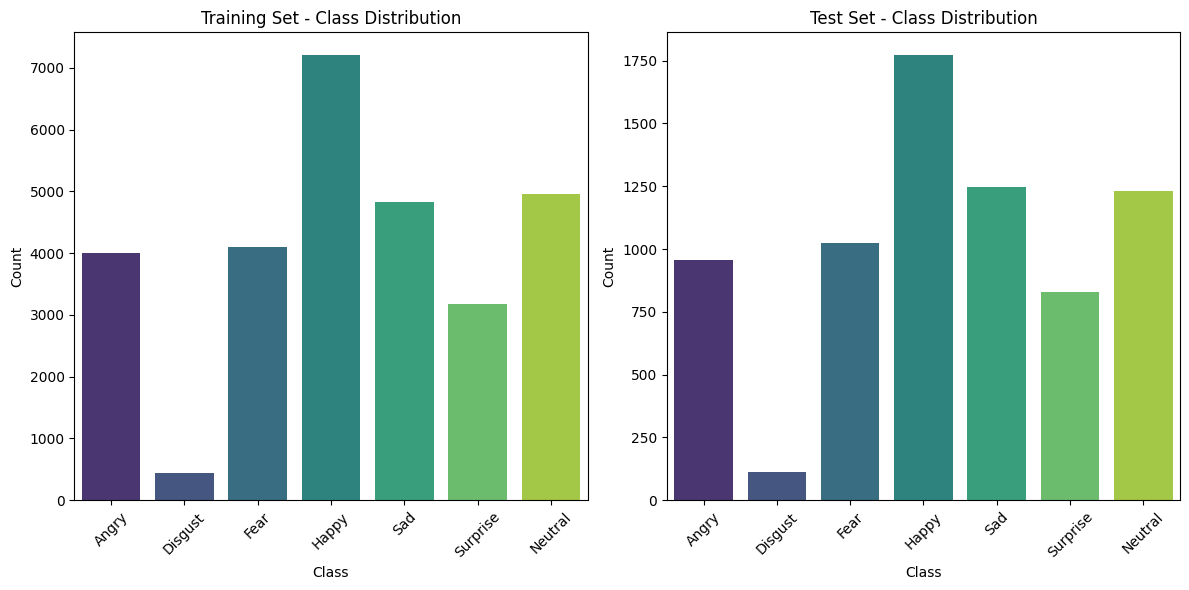

In [11]:
plot_class_distribution(train_labels, test_labels, labels)

In [12]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

## Visualizing the data

torch.Size([128, 1, 48, 48])


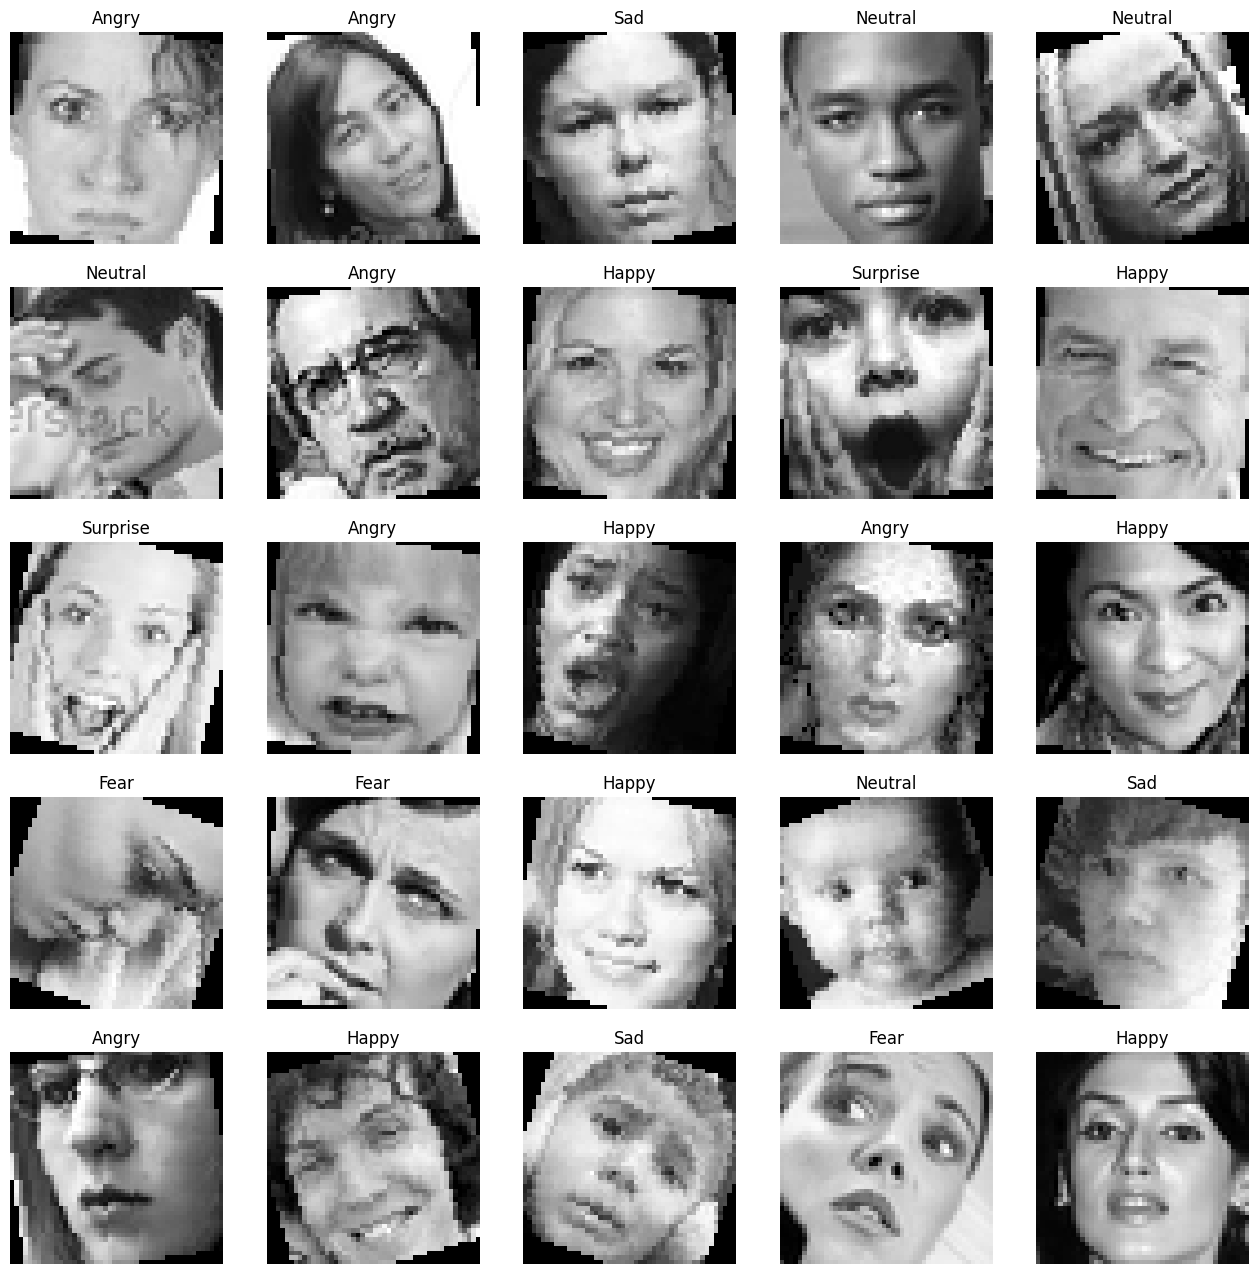

In [13]:
labels_dict = {idx: label for idx, label in enumerate(labels)}

for images, labels in train_loader:
    plt.figure(figsize=(16, 16))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().transpose(1, 2, 0), cmap="gray")
        plt.title(labels_dict[labels[i].item()])
        plt.axis("off")
    break

images, labels = next(iter(train_loader))
print(images.shape)

## Defining the model architecture

In [14]:
class EmotioNet(nn.Module):
    def __init__(self):
        super(EmotioNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),

            nn.Linear(512, 7)
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
model = EmotioNet()
model = model.to(device)

print(model)

EmotioNet(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [16]:
_ = summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          18,496
              ReLU-4           [-1, 64, 48, 48]               0
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         MaxPool2d-6           [-1, 64, 24, 24]               0
           Dropout-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         204,928
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
        MaxPool2d-11          [-1, 128, 12, 12]               0
          Dropout-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 512, 12, 12]         590,336
             ReLU-14          [-1, 512,

## Train and validation functions

In [17]:
@torch.no_grad()
def validate(model, criterion, validation_loader, device):
    model.eval()

    accuracy = 0.0
    loss = 0.0

    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)

        batch_loss = criterion(output, target).data.item() * data.shape[0]
        loss += batch_loss

        _, predicted = torch.max(output, axis=1)
        accuracy += (predicted == target).sum().item()

    accuracy /= len(validation_loader.dataset)
    loss /= len(validation_loader.dataset)
    return accuracy, loss

In [18]:
def save_model(model, epoch, val_loss, optimizer):
    state = {
        "model": model.state_dict(),
        "epoch": epoch,
        "val_loss": val_loss,
        "optimizer": optimizer.state_dict(),
    }
    date_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    path = "checkpoints/checkpoint_epoch_{}_val_loss_{:.3f}_{}.pt".format(
        epoch, val_loss, date_time
    )
    torch.save(state, path)

In [19]:
def load_model(path, model, optimizer=None):
    state = torch.load(path)
    model.load_state_dict(state["model"])
    epoch = state["epoch"]
    val_loss = state["val_loss"]
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])
    return epoch, val_loss

In [20]:
def train(model, epochs, criterion, train_loader, validation_loader, optimizer, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    best_validation_loss = None

    for epoch in range(1, epochs + 1):
        model.train()

        running_train_loss = 0.0
        accuracy = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = criterion(output, target)
            running_train_loss += loss.item() * data.shape[0]

            _, predicted = torch.max(output, axis=1)
            accuracy += (predicted == target).sum().item()

            model.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(running_train_loss / len(train_loader.dataset))
        train_accuracies.append(accuracy / len(train_loader.dataset))
        validation_accuracy, validation_loss = validate(
            model, criterion, validation_loader, device
        )
        print(
            f"Epoch {epoch}/{epochs}, validation set: acc={validation_accuracy * 100:.2f}%, loss={validation_loss:.4f}"
        )
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        if not best_validation_loss or validation_loss < best_validation_loss:
            save_model(model, epoch, validation_loss, optimizer)
            best_validation_loss = validation_loss

    return train_losses, train_accuracies, validation_losses, validation_accuracies

## Training

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

In [ ]:
# train_losses, train_accuracies, validation_losses, validation_accuracies = train(
#     model=model,
#     epochs=50,
#     criterion=criterion,
#     train_loader=train_loader,
#     validation_loader=validation_loader,
#     optimizer=optimizer,
#     device=device,
# )

Epoch 1/50, validation set: acc=24.90%, loss=1.9199
Epoch 2/50, validation set: acc=31.64%, loss=1.7929
Epoch 3/50, validation set: acc=34.08%, loss=1.7486
Epoch 4/50, validation set: acc=37.27%, loss=3.9881
Epoch 5/50, validation set: acc=42.73%, loss=2.6373
Epoch 6/50, validation set: acc=44.90%, loss=2.5328
Epoch 7/50, validation set: acc=48.80%, loss=1.6348
Epoch 8/50, validation set: acc=50.60%, loss=1.3318
Epoch 9/50, validation set: acc=53.25%, loss=1.2370
Epoch 10/50, validation set: acc=54.26%, loss=1.1818
Epoch 11/50, validation set: acc=55.54%, loss=1.1610
Epoch 12/50, validation set: acc=56.80%, loss=1.1372
Epoch 13/50, validation set: acc=57.95%, loss=1.1017
Epoch 14/50, validation set: acc=57.83%, loss=1.0986
Epoch 15/50, validation set: acc=58.40%, loss=1.1027
Epoch 16/50, validation set: acc=59.97%, loss=1.0894
Epoch 17/50, validation set: acc=59.85%, loss=1.0616
Epoch 18/50, validation set: acc=61.03%, loss=1.0297
Epoch 19/50, validation set: acc=60.70%, loss=1.0330
Ep

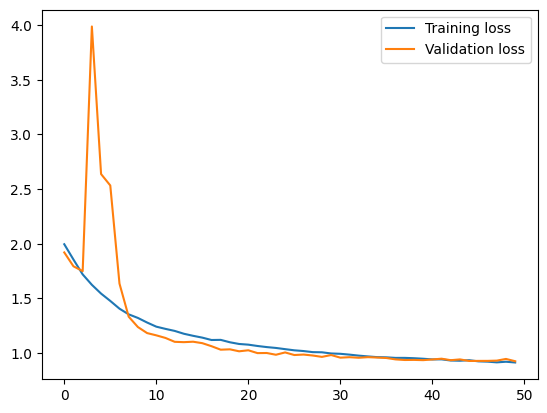

In [ ]:
# plt.plot(train_losses, label="Training loss")
# plt.plot(validation_losses, label="Validation loss")
# plt.legend()
# plt.show()

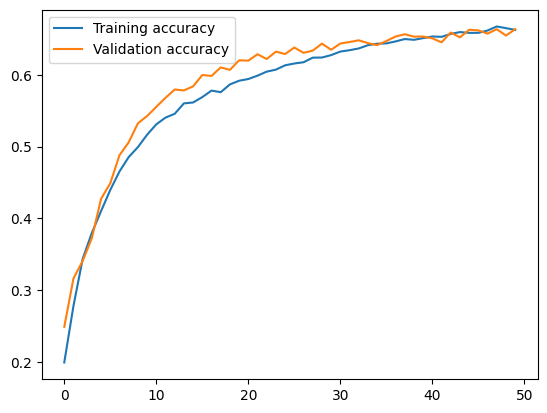

In [ ]:
# plt.plot(train_accuracies, label="Training accuracy")
# plt.plot(validation_accuracies, label="Validation accuracy")
# plt.legend()
# plt.show()

## Results

In [22]:
_ = load_model(
    "./checkpoints/checkpoint_epoch_50_val_loss_0.924_2024-01-04-22-34-05.pt", model
)

In [23]:
start_eval = time.time()
accuracy, _ = validate(model, criterion, validation_loader, device)
end_eval = time.time()

In [24]:
print(f"Final accuracy on validation split: {accuracy * 100:.2f}%")
print(f"Evaluation took {end_eval - start_eval:.2f}s")

Final accuracy on validation split: 66.36%
Evaluation took 2.62s


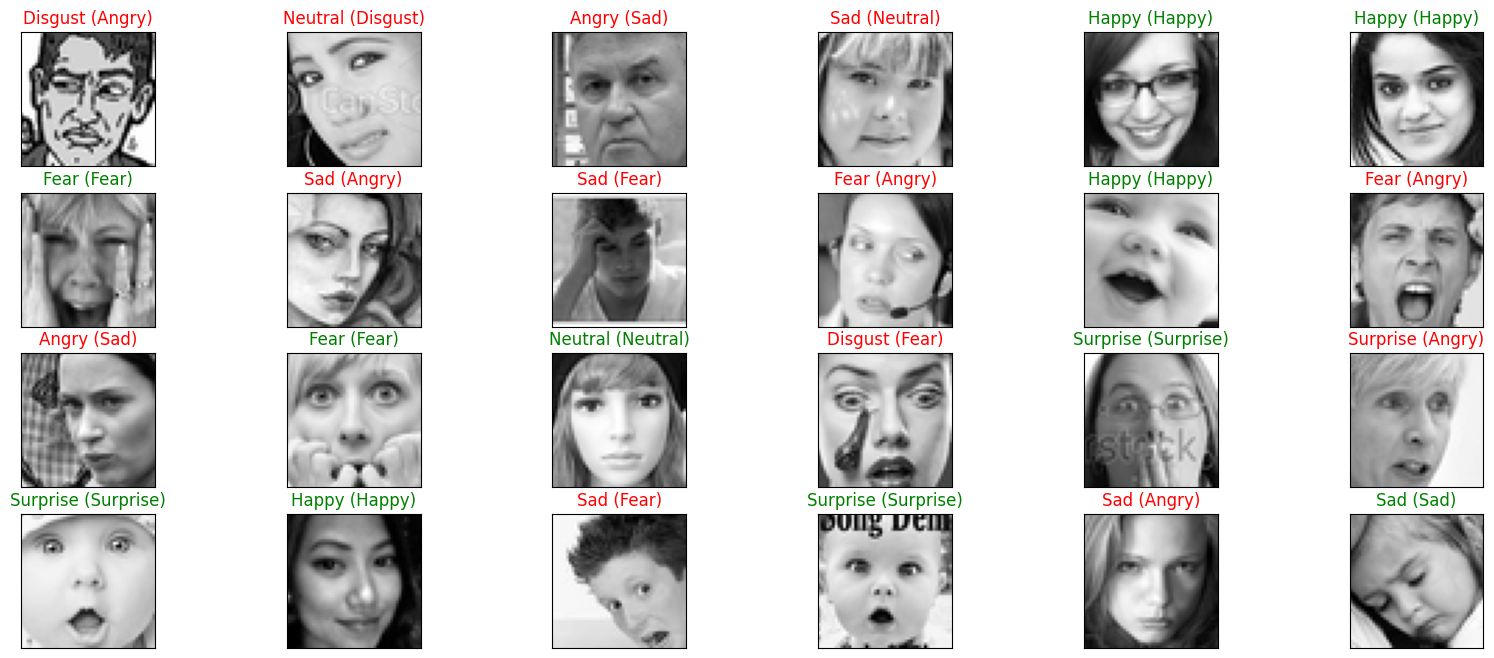

In [25]:
figure = plt.figure(figsize=(20, 8))
for idx, (image, label) in enumerate(validation_dataset):
    if idx == 24:
        break
    ax = figure.add_subplot(4, 6, idx + 1, xticks=[], yticks=[])
    ax.imshow(image.numpy().transpose(1, 2, 0), cmap="gray")
    output = model(image.unsqueeze(0).to(device))
    predicted_label = labels_dict[torch.max(output, axis=1)[1].item()]
    actual_label = labels_dict[label]

    ax.set_title(
        "{} ({})".format((predicted_label), (actual_label)),
        color=("green" if predicted_label == actual_label else "red"),
    )

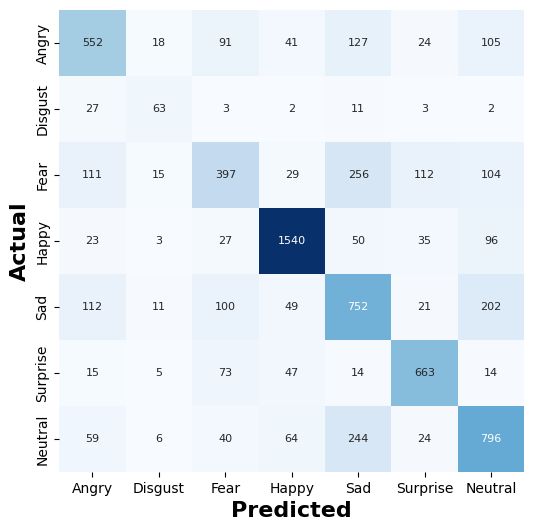

In [26]:
predicted = []
actual = []

model.eval()
with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, axis=1)

        predicted.extend(preds.tolist())
        actual.extend(labels.tolist())

conf_matrix = confusion_matrix(
    actual,
    predicted,
)

emotions = list(labels_dict.values())

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=emotions,
    yticklabels=emotions,
    annot_kws={"size": 8},
)
plt.xlabel("Predicted", fontdict={"size": 16, "weight": "bold"})
plt.ylabel("Actual", fontdict={"size": 16, "weight": "bold"})
plt.show()